In [31]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D

In [36]:
box_dir = "C:/Users/mmedeng/Documents/repositories/NUAGES_DE_POINTS/ANNOTATIONS/np_data"
boxes = glob.glob(box_dir + '/*.npy')
boxes.sort()
coors = []
mask = np.zeros((1,3))

for i in range(len(boxes)):
    coors.append(np.load(boxes[i])[:, 1:4])
    coors[i] = coors[i][coors[i] != mask]
    coors[i] = coors[i].reshape(coors[i].shape[0]//3, 3)
coors = np.vstack(coors)
coors.shape

(2456, 3)

In [41]:
# Apply DBSCAN clustering
dbscan = DBSCAN(min_samples=3).fit(coors)
labels = dbscan.labels_

# Extract cluster centers
unique_labels = set(labels)
cluster_centers = []
for label in unique_labels:
    points_in_cluster = coors[labels == label]
    cluster_center = points_in_cluster.mean(axis=0)
    cluster_centers.append(cluster_center)

cluster_centers = np.array(cluster_centers)
print(cluster_centers)  # Use these as anchor box centers

[[246.15001547 221.52402593  10.750972  ]
 [247.05656808 220.33516364  10.80037832]
 [262.82808362 252.97089114  14.08957264]
 [263.76298889 251.73740937  14.04021053]
 [225.32820215 250.45016987  10.72617459]
 [227.75748104 252.10361184  10.2409246 ]
 [240.96582351 260.41805244  13.72054958]
 [254.90233281 268.89172265  13.68229961]
 [ 86.81120532 496.56235526  14.06142426]
 [ 87.20760942 495.80077811  14.28342438]
 [ 70.50680646 518.97276651  13.68854952]
 [104.23736964 223.76459565  12.13455549]
 [105.19132131 226.34931661  11.39542627]
 [ 79.86201772 319.36874417   8.80805135]
 [ 79.46719756 316.42314973  11.34917593]
 [ 34.87152968 382.272784     7.9265511 ]
 [342.03734602 538.6708361   29.96879513]]


In [9]:
def generate_anchors(center, scales, aspect_ratios):
    anchors = []
    for scale in scales:
        for aspect_ratio in aspect_ratios:
            w, l, h, yaw = scale * aspect_ratio[0], scale * aspect_ratio[1], scale * aspect_ratio[2], aspect_ratio[3]
            anchor = [center[0], center[1], center[2], w, l, h, yaw]  # Assuming (x, y, z, w, h, l, yaw)
            anchors.append(anchor)
    return anchors

# Define scales and aspect ratios
scales = [1, 2, 3]  # Example scales
aspect_ratios = [(1.75, 1.75, 2.6, 0), (6.75, 2.75, 3.5, 1.5708), (9.2, 4.0, 22.5, 0), (1.4, 1.0, 1.9, 1.5708)]  # Example aspect ratios

# Generate anchors around each cluster center
all_anchors = []
for center in cluster_centers:
    anchors = generate_anchors(center, scales, aspect_ratios)
    all_anchors.extend(anchors)

all_anchors = np.array(all_anchors)
print(all_anchors)  # Use these as anchor boxes

[[246.15001547 221.52402593  10.750972   ...   1.75         2.6
    0.        ]
 [246.15001547 221.52402593  10.750972   ...   2.75         3.5
    1.5708    ]
 [246.15001547 221.52402593  10.750972   ...   4.          22.5
    0.        ]
 ...
 [342.03734602 538.6708361   29.96879513 ...   8.25        10.5
    1.5708    ]
 [342.03734602 538.6708361   29.96879513 ...  12.          67.5
    0.        ]
 [342.03734602 538.6708361   29.96879513 ...   3.           5.7
    1.5708    ]]


In [3]:
seed = np.random.seed(42)
k_means = KMeans(n_clusters=4, random_state=42)
clusters = k_means.fit_transform(coors)
anchors = k_means.cluster_centers_
print("Anchor Boxes (Width, Length, Height):\n", anchors)

Anchor Boxes (Width, Length, Height):
 [[ 273.19412191 1047.99536172   26.99545249]
 [ 303.61540044  559.77849235   27.91218802]
 [ 768.21475193  577.63874027   30.43867836]
 [ 227.70253351  210.9390724    32.02111011]]


C:\Users\mmedeng\AppData\Local\Temp\ipykernel_11684\3226446597.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(coors[:, 0], coors[:, 1], coors[:, 2], c=normalized_clusters, cmap='viridis')


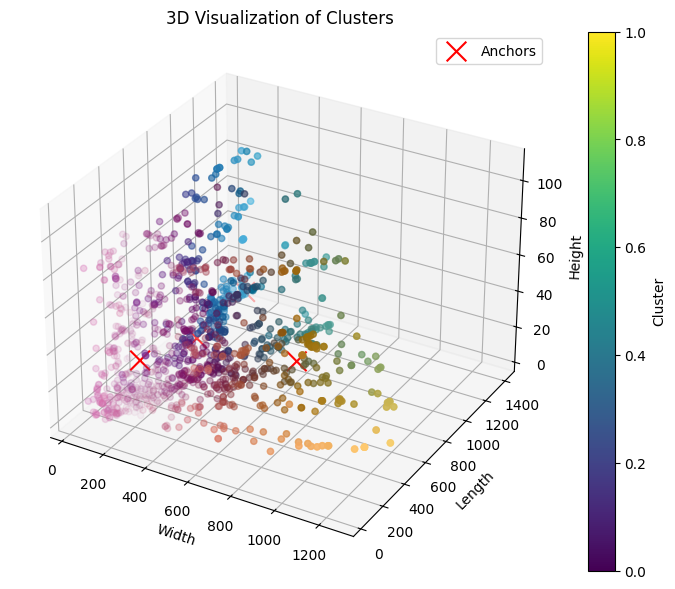

In [4]:
normalized_clusters = clusters / clusters.max()

# Visualize the clusters in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data points colored by their cluster
scatter = ax.scatter(coors[:, 0], coors[:, 1], coors[:, 2], c=normalized_clusters, cmap='viridis')

# Scatter plot of the cluster centers
ax.scatter(anchors[:, 0], anchors[:, 1], anchors[:, 2], c='red', marker='x', s=200, label='Anchors')

# Setting labels
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('Width')
ax.set_ylabel('Length')
ax.set_zlabel('Height')
plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.show()
